In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Embedding, SpatialDropout1D, Bidirectional, Input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import random

In [ ]:
# ---------------- Load Dataset ----------------
df = pd.read_csv('malicious_phish.csv')
df['label'] = df['type'].map({'benign': 0, 'defacement': 1, 'phishing': 2, 'malware': 3})


In [ ]:
# ---------------- Tokenization ----------------
char_set = sorted(set(''.join(df['url'])))
char_to_index = {char: i + 1 for i, char in enumerate(char_set)}
index_to_char = {i + 1: char for i, char in enumerate(char_set)}
max_length = min(100, max(len(url) for url in df['url']))  # Limit URL length to 100

def encode_url(url):
    return [char_to_index[c] for c in url if c in char_to_index]

# Reduce dataset size for GAN training
df_sample = df.sample(50000)  # Use only 50,000 URLs for GAN training
X_gan = [encode_url(url) for url in df_sample['url']]
X_gan = pad_sequences(X_gan, maxlen=max_length, padding='post')

In [ ]:
# ---------------- LSTM Generator ----------------
generator = Sequential([
    LSTM(64, return_sequences=True, input_shape=(max_length, 1)),
    LSTM(64, return_sequences=False),
    Dense(max_length, activation='softmax')
])

# ---------------- LSTM Discriminator ----------------
discriminator = Sequential([
    LSTM(64, return_sequences=True, input_shape=(max_length, 1)),
    LSTM(64, return_sequences=False),
    Dense(1, activation='sigmoid')
])

discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# ---------------- GAN ----------------
discriminator.trainable = False
gan_input = Input(shape=(max_length, 1))
generated_urls = generator(gan_input)
gan_output = discriminator(generated_urls)
gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')


In [ ]:
# ---------------- Train GAN ----------------
batch_size = 512  # Use mini-batch training
real_labels = np.ones((batch_size, 1))
fake_labels = np.zeros((batch_size, 1))

for epoch in range(1000):  # Reduce epochs to avoid long training time
    idx = np.random.randint(0, len(X_gan), batch_size)
    real_samples = X_gan[idx]

    noise = np.random.normal(0, 1, (batch_size, max_length, 1))
    generated_urls = generator.predict(noise)

    # Train Discriminator
    discriminator.trainable = True
    d_loss_real = discriminator.train_on_batch(real_samples, real_labels)
    d_loss_fake = discriminator.train_on_batch(generated_urls, fake_labels)

    # Train Generator
    discriminator.trainable = False
    noise = np.random.normal(0, 1, (batch_size, max_length, 1))
    gan_loss = gan.train_on_batch(noise, real_labels)

    if epoch % 200 == 0:
        print(f'Epoch {epoch}, D Loss: {d_loss_real[0] + d_loss_fake[0]}, G Loss: {gan_loss}')

# ---------------- Generate Fake URLs ----------------
noise = np.random.normal(0, 1, (5000, max_length, 1))
fake_urls_encoded = generator.predict(noise)
fake_urls = [''.join(index_to_char.get(int(c), '') for c in url if int(c) in index_to_char) for url in fake_urls_encoded]


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Epoch 0, D Loss: 1.4078240394592285, G Loss: 0.6848295331001282
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [ ]:
# ---------------- Feature Extraction ----------------
def extract_features(url):
    return [len(url), url.count('.'), url.count('/'), url.count('-'), url.count('_'),
            sum(c.isdigit() for c in url), sum(c.isalpha() for c in url),
            url.count('https'), url.count('http'), url.count('www')]

fake_features = np.array([extract_features(url) for url in fake_urls])
fake_labels = np.random.randint(0, 4, 5000)

In [ ]:
# ---------------- Train-Test Split ----------------
X = np.array(df['url'].apply(extract_features).tolist())
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_aug = np.vstack((X_train, fake_features))
y_train_aug = np.hstack((y_train, fake_labels))

In [ ]:
# ---------------- SVM Feature Extraction ----------------
svm_samples = min(10000, len(X_train))  # Avoid training SVM on entire dataset
svm_model = SVC(probability=True)
svm_model.fit(X_train[:svm_samples], y_train[:svm_samples])

svm_features_train = svm_model.predict_proba(X_train[:svm_samples])
svm_features_test = svm_model.predict_proba(X_test[:len(svm_features_train)])

X_train_combined = np.hstack((X_train[:svm_samples], svm_features_train))
X_test_combined = np.hstack((X_test[:len(svm_features_test)], svm_features_test))


In [ ]:
# ---------------- Ensemble Model ----------------
rf = RandomForestClassifier(n_estimators=100)
xgb = XGBClassifier()
lgb = LGBMClassifier()
ensemble = VotingClassifier(estimators=[('rf', rf), ('xgb', xgb), ('lgb', lgb)], voting='soft')
ensemble.fit(X_train_combined, y_train[:svm_samples])  # Use same subset as SVM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1595
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 14
[LightGBM] [Info] Start training from score -0.410076
[LightGBM] [Info] Start training from score -1.935168
[LightGBM] [Info] Start training from score -1.958286
[LightGBM] [Info] Start training from score -2.977892


VotingClassifier(estimators=[('rf', RandomForestClassifier()),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('lgb', LGBMClassifier())],
                 voting='soft')

In [ ]:
# ---------------- Classification ----------------
def classify_url(url):
    features = np.array(extract_features(url)).reshape(1, -1)
    svm_probs = svm_model.predict_proba(features)  # Add SVM features
    features_combined = np.hstack((features, svm_probs))
    pred = ensemble.predict(features_combined)
    labels = ['benign', 'defacement', 'phishing', 'malware']
    return labels[pred[0]]

user_url = input("Enter a URL for classification: ")
print("Predicted Category:", classify_url(user_url))

Enter a URL for classification: https://pay-pal.com
Predicted Category: phishing


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


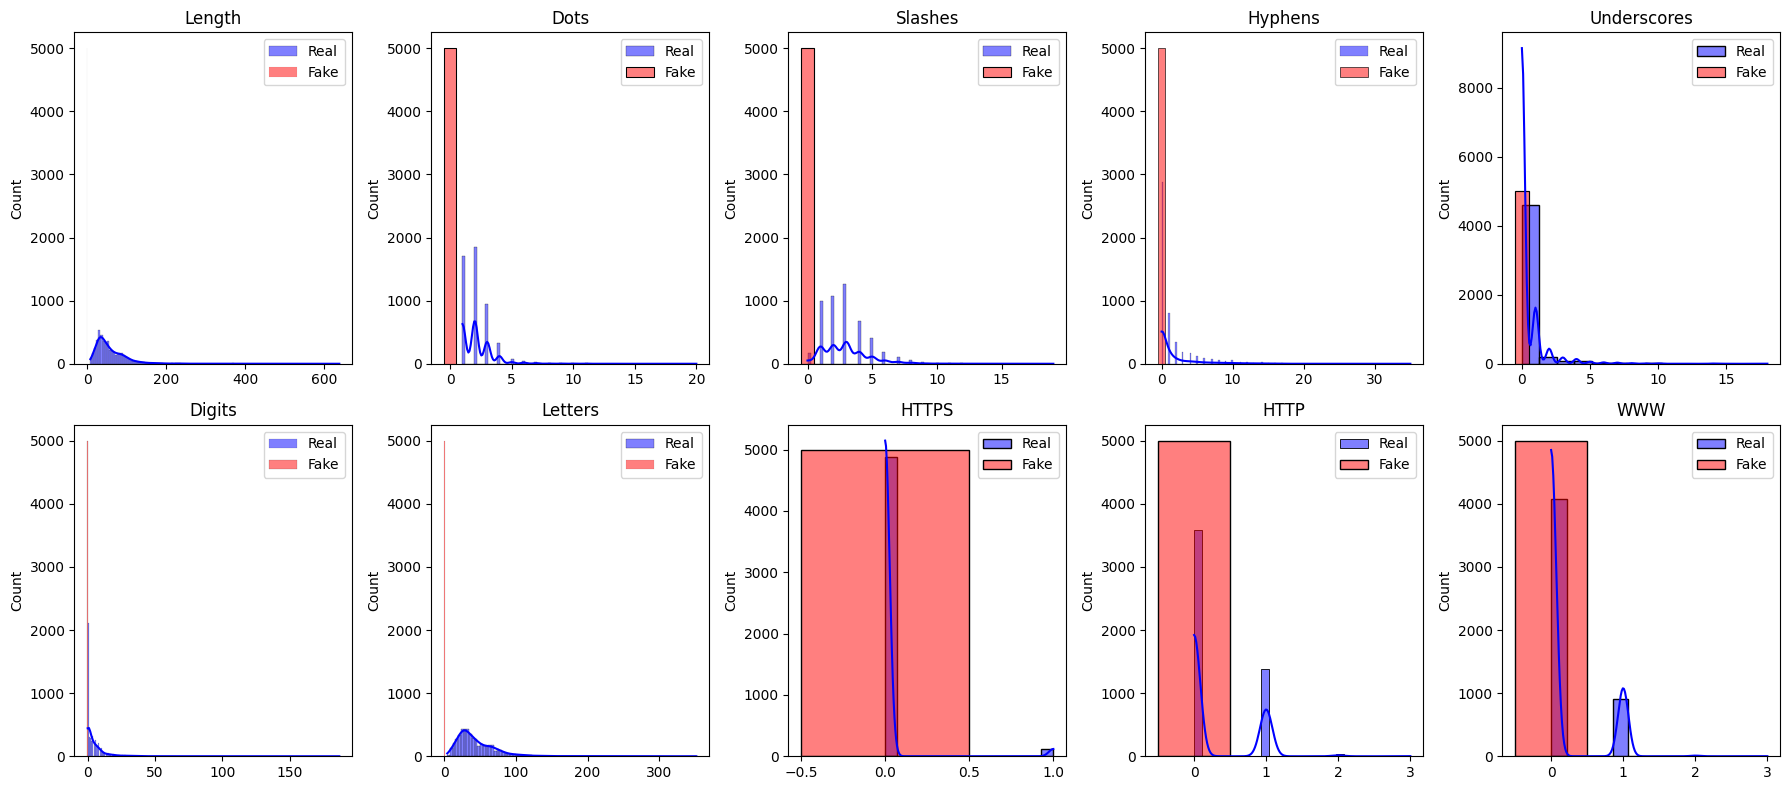

In [ ]:
# ---------------- Feature Distribution: Fake vs Real ----------------
real_feature_sample = np.array([extract_features(url) for url in df['url'].sample(5000)])
fake_feature_sample = np.array([extract_features(url) for url in fake_urls[:5000]])

feature_names = ['Length', 'Dots', 'Slashes', 'Hyphens', 'Underscores', 'Digits', 'Letters', 'HTTPS', 'HTTP', 'WWW']
fig, axes = plt.subplots(2, 5, figsize=(18, 8))

for i, ax in enumerate(axes.flat):
    sns.histplot(real_feature_sample[:, i], kde=True, color='blue', label='Real', ax=ax)
    sns.histplot(fake_feature_sample[:, i], kde=True, color='red', label='Fake', ax=ax)
    ax.set_title(feature_names[i])
    ax.legend()

plt.tight_layout()
plt.show()

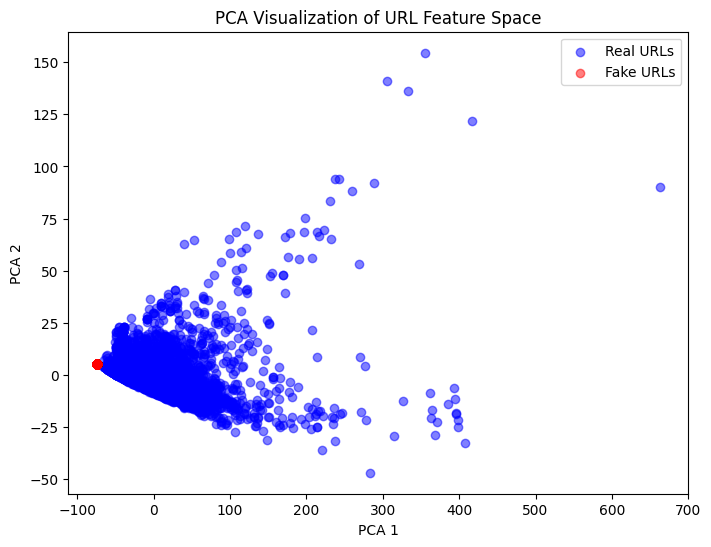

In [ ]:
# ---------------- PCA Visualization of Feature Space ----------------
pca = PCA(n_components=2)
real_pca = pca.fit_transform(real_feature_sample)
fake_pca = pca.transform(fake_feature_sample)

plt.figure(figsize=(8, 6))
plt.scatter(real_pca[:, 0], real_pca[:, 1], alpha=0.5, label='Real URLs', color='blue')
plt.scatter(fake_pca[:, 0], fake_pca[:, 1], alpha=0.5, label='Fake URLs', color='red')
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA Visualization of URL Feature Space")
plt.legend()
plt.show()


In [ ]:
# ---------------- Model Evaluation ----------------
y_pred = ensemble.predict(X_test_combined)
print("\nClassification Report:\n", classification_report(y_test[:len(y_pred)], y_pred))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.96      6624
           1       0.91      0.94      0.93      1435
           2       0.82      0.74      0.78      1426
           3       0.89      0.83      0.86       515

    accuracy                           0.93     10000
   macro avg       0.89      0.87      0.88     10000
weighted avg       0.93      0.93      0.93     10000



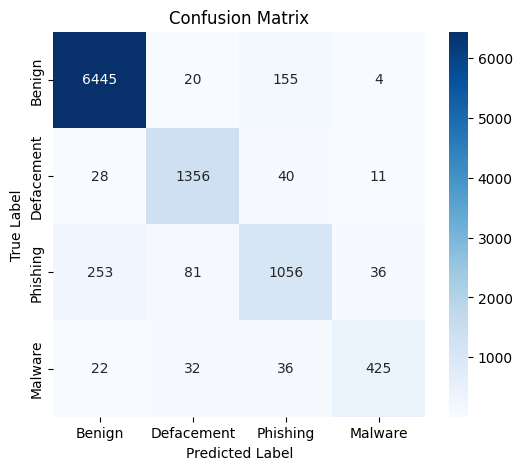

In [ ]:
# ---------------- Confusion Matrix ----------------
conf_matrix = confusion_matrix(y_test[:len(y_pred)], y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Benign', 'Defacement', 'Phishing', 'Malware'],
            yticklabels=['Benign', 'Defacement', 'Phishing', 'Malware'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


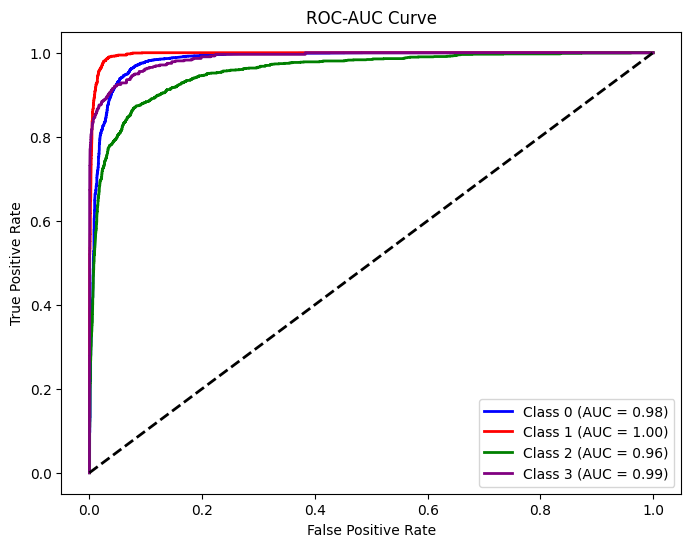

In [ ]:
# ---------------- ROC-AUC Curve ----------------
y_test_bin = label_binarize(y_test[:len(y_pred)], classes=[0, 1, 2, 3])
y_score = ensemble.predict_proba(X_test_combined)

plt.figure(figsize=(8, 6))
colors = cycle(['blue', 'red', 'green', 'purple'])
for i, color in zip(range(4), colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, label=f"Class {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve")
plt.legend(loc="lower right")
plt.show()
